CSV saved to: D:\Stelco\Work\Dynamic Correlation\Key\Cross Correlation\5514593_Neet Oil Concentration__Operator_Q_VW_OLD_OPTECH__3phase_summary.csv


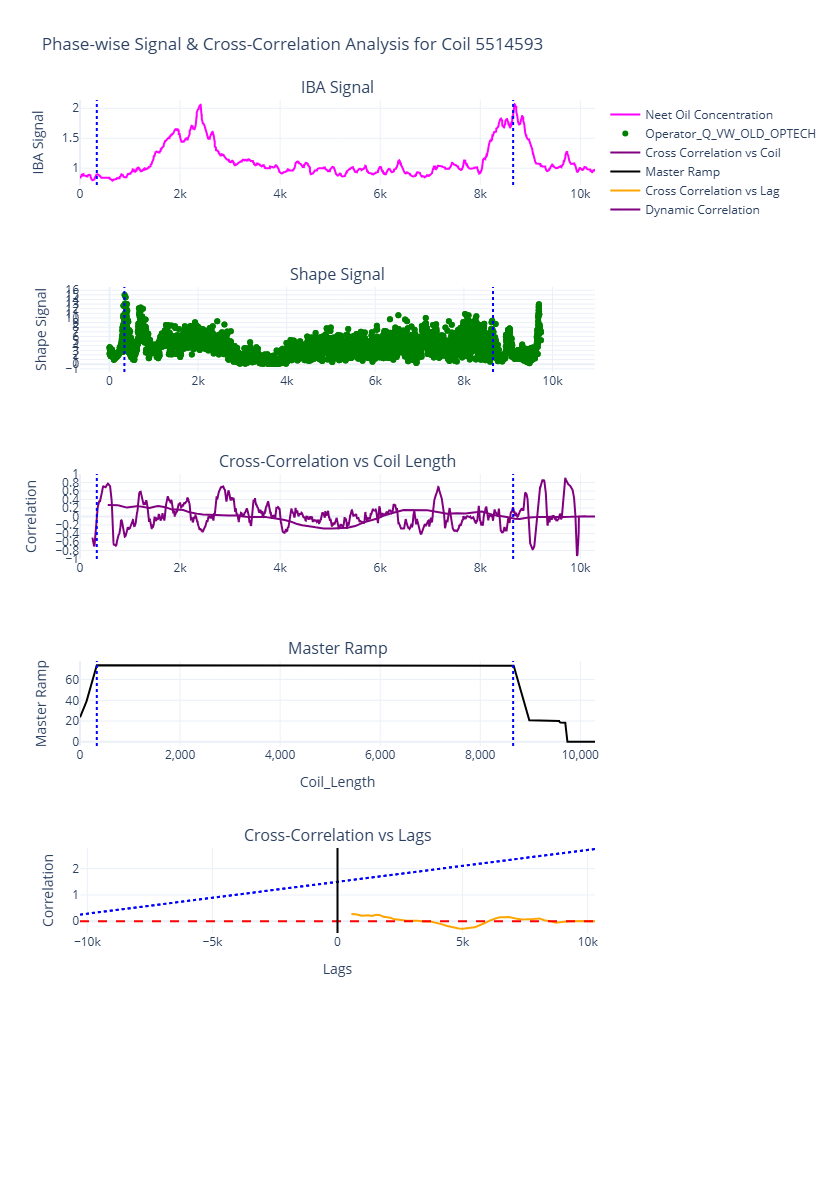


Completed in: 0:00:03.822316


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime
from scipy import signal

start_time = datetime.now()  # Start timer

def ccf_values(series1, series2):
    p = (series1 - np.mean(series1)) / (np.std(series1) * len(series1))
    q = (series2 - np.mean(series2)) / (np.std(series2))
    ccf = np.correlate(p, q, 'full')
    return ccf

def plot_phasewise_signals_with_ccf(df, coil_id, continuous_col, discrete_col, 
                                    ramp_col, coil_length_col, phase1_end, phase2_end, save_path=None):

    corr_col = continuous_col+"_Rolling_Corr_"+discrete_col
    # Cross-correlation calculation
    ccf = ccf_values(df[continuous_col], df[discrete_col])
    lags = signal.correlation_lags(len(df[continuous_col]), len(df[discrete_col]))
    
    fig = make_subplots(rows=6, cols=1, shared_xaxes=False, vertical_spacing=0.1,
                        subplot_titles=[
                            "IBA Signal", 
                            "Shape Signal", 
                            "Cross-Correlation vs Coil Length", 
                            "Master Ramp",
                            "Cross-Correlation vs Lags"  # new subplot added
                        ])

    coil_length_values = df[coil_length_col]

    # Original subplots
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[continuous_col], mode="lines", name=continuous_col,
                             line=dict(color="magenta")), row=1, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[discrete_col], mode="markers", name=discrete_col,
                             marker=dict(color="green", size=6)), row=2, col=1)

    fig.add_trace(go.Scatter(x=coil_length_values, y=ccf[len(ccf)//2:len(ccf)//2+len(coil_length_values)], 
                             mode="lines", name="Cross Correlation vs Coil", line=dict(color="purple")), row=3, col=1)

    fig.add_trace(go.Scatter(x=coil_length_values, y=df[ramp_col], mode="lines", name=ramp_col,
                             line=dict(color="black")), row=4, col=1)

    # New subplot: cross-correlation vs lag
    fig.add_trace(go.Scatter(x=lags, y=ccf, mode="lines", name="Cross Correlation vs Lag",
                             line=dict(color="orange")), row=5, col=1)

    fig.add_trace(go.Scatter(x=coil_length_values, y=df[corr_col], mode="lines", name="Dynamic Correlation",
                         line=dict(color="purple")), row=3, col=1)

    
    # Reference lines for lag plot
    fig.add_hline(y=0, line=dict(color="red", dash="dash"), row=5, col=1)
    fig.add_hline(y=np.max(ccf), line=dict(color="blue", dash="dot"), row=5, col=1)
    fig.add_hline(y=np.min(ccf), line=dict(color="blue", dash="dot"), row=5, col=1)
    fig.add_vline(x=0, line=dict(color="black"), row=5, col=1)

    # Phase boundary vertical lines
    x1 = df[coil_length_col].iloc[phase1_end]
    x2 = df[coil_length_col].iloc[phase2_end]
    for row in [1, 2, 3, 4]:
        fig.add_vline(x=x1, line=dict(color="blue", dash="dot"), row=row, col=1)
        fig.add_vline(x=x2, line=dict(color="blue", dash="dot"), row=row, col=1)

    # Y-axis and X-axis labels
    fig.update_yaxes(title_text="\nIBA Signal", row=1, col=1)
    fig.update_yaxes(title_text="\nShape Signal", dtick=1, row=2, col=1)
    fig.update_yaxes(title_text="\nCorrelation", range=[-1, 1], dtick=0.2, row=3, col=1)
    fig.update_yaxes(title_text="\nMaster Ramp", row=4, col=1)
    fig.update_yaxes(title_text="\nCorrelation", row=5, col=1)

    fig.update_xaxes(title_text=coil_length_col, tickformat=",.0f", row=4, col=1)
    fig.update_xaxes(title_text="Lags", row=5, col=1)

    # Layout
    fig.update_layout(
        title_text=f"\nPhase-wise Signal & Cross-Correlation Analysis for Coil {coil_id}",
        height=1200,
        template="plotly_white",
        showlegend=True
    )

    fig.show()

def cross_corr_phasewise(file_path, iba_signal, shape_feature, output_dir='output', ramp_col="Master Ramp"):
    
    df = pd.read_csv(file_path)
    
    if df[ramp_col].max() <= 15:
        return []

    norm_val = df[ramp_col].mode()[0]
    norm_df = df[df[ramp_col] == norm_val]
    if norm_df.empty:
        return []

    phase1_end = norm_df.index[0]
    phase2_end = norm_df.index[-1]
    phases = {
        'Phase 1': df.iloc[:phase1_end + 1],
        'Phase 2': df.iloc[phase1_end:phase2_end + 1],
        'Phase 3': df.iloc[phase2_end + 1:]
    }

    summary = []
    for phase_name, df_phase in phases.items():
        px = df_phase[iba_signal].dropna()
        py = df_phase[shape_feature].dropna()

        # Align lengths
        min_len = min(len(px), len(py))
        if min_len < 2:
            continue

        px = px[:min_len]
        py = py[:min_len]

        # Cross correlation
        cross_corr_vals = np.correlate(px - px.mean(), py - py.mean(), mode='full')
        lags = np.arange(-len(px) + 1, len(px))
        best_lag = lags[np.argmax(cross_corr_vals)]
        max_corr = np.max(cross_corr_vals)

        summary.append({
            'Coil_ID': os.path.basename(file_path).split('.')[0],
            'Phase': phase_name,
            'IBA_Signal': iba_signal,
            'Shape_Feature': shape_feature,
            'Best_Lag': best_lag,
            'Max_Cross_Corr': max_corr
        })

    # Summary CSV
    summary_df = pd.DataFrame(summary)
    csv_path = os.path.join(output_dir, f"{os.path.basename(file_path).split('.')[0]}_{iba_signal}__{shape_feature}__3phase_summary.csv")
    # summary_df.to_csv(csv_path, index=False)
    print(f"CSV saved to: {csv_path}")

    # # Heatmap
    # if not summary_df.empty:
    #     heatmap_data = summary_df.pivot(index="Phase", columns="Shape_Feature", values="Max_Cross_Corr")
    #     plt.figure(figsize=(8, 4))
    #     sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", linewidths=0.5)
    #     plt.title(f"3-Phase Cross-Correlation Heatmap\n{iba_signal}")
    #     plt.tight_layout()
    #     heatmap_path = os.path.join(output_dir, f"{os.path.basename(file_path).split('.')[0]}_{iba_signal}__3phase_heatmap.png")
    #     plt.savefig(heatmap_path)
    #     plt.show()
    #     print(f"Heatmap saved to: {heatmap_path}")

    # ----- Rolling correlation for Plotly plot -----
    window_size = 30
    df['rolling_corr'] = df[iba_signal].rolling(window_size).corr(df[shape_feature])
    
    if 'Coil_Length' not in df.columns:
        df['Coil_Length'] = np.arange(len(df))  # fallback if Coil_Length not present

    coil_id = os.path.basename(file_path).split('.')[0]
    plot_path = os.path.join(output_dir, f"{coil_id}_{iba_signal}__{shape_feature}__interactive_plot.html")
    plot_phasewise_signals_with_ccf(
        df=df,
        coil_id=coil_id,
        continuous_col=iba_signal,
        discrete_col=shape_feature,
        ramp_col=ramp_col,
        coil_length_col='Coil_Length',
        phase1_end=phase1_end,
        phase2_end=phase2_end,
        save_path=plot_path
    )


cross_corr_phasewise(
    file_path = r"D:\Stelco\Work\Dynamic Correlation\Key\Master whole Phase\5514593.csv",
    # file_path = "5418920.csv",
    iba_signal ='Neet Oil Concentration',
    # iba_signal ='Stand 4 DS Total Bending Feedback',
    shape_feature='Operator_Q_VW_OLD_OPTECH',
    output_dir=r"D:\Stelco\Work\Dynamic Correlation\Key\Cross Correlation"
    # output_dir = r"D:\Arpita SpringRiver\Data Science\Stelco\IBA_Shape Data for Correlation Analysis"
)
# End timer
end_time = datetime.now()
elapsed = end_time - start_time
print(f"\nCompleted in: {elapsed}")


## Dynamic Correlation Plot

In [11]:
file_path = r"D:\Stelco\Work\Dynamic Correlation\Key\Master whole Phase\5454320.csv"
continuous_col ='Stand 1 Gap Thread Offset'
discrete_col='Driver_Q_VW_OLD_OPTECH'
coil_length_col = 'Coil_Length'
df = pd.read_csv(file_path)

# Compute rolling correlation
window_size = 50  # You can tweak this value
df['rolling_corr'] = df[continuous_col].rolling(window=window_size).corr(df[discrete_col])

fig = go.Figure()

# Add subplot row for rolling correlation
fig.add_trace(go.Scatter(
    x=df[coil_length_col],
    y=df['rolling_corr'],
    mode='lines',
    name=f'Rolling Corr (w={window_size})',
    line=dict(color='teal')
), row=6, col=1)

# Update Y and X axis labels
fig.update_yaxes(title_text="Rolling Corr", row=6, col=1)
fig.update_xaxes(title_text=coil_length_col, row=6, col=1)

KeyError: 'Coil_Length'